# YelpReviewFull 完整数据集微调训练

## 作业目标
使用完整的 YelpReviewFull 数据集训练，对比看 Acc 最高能到多少。

## 数据集信息
- **训练集**：650,000 条评论
- **测试集**：50,000 条评论
- **类别数**：5 类（1-5星评分）

## 实验策略
1. 使用完整数据集（不使用抽样）
2. 尝试不同的超参数组合
3. 对比不同模型的准确率
4. 找到最高准确率配置


In [ ]:
# 安装必要的库
!pip install -q transformers datasets accelerate evaluate


## 1. 加载完整数据集


In [ ]:
from datasets import load_dataset

# 加载完整的 YelpReviewFull 数据集
print("正在加载 YelpReviewFull 数据集...")
dataset = load_dataset("yelp_review_full")
print(f"数据集加载完成！")
print(f"训练集大小: {len(dataset['train']):,}")
print(f"测试集大小: {len(dataset['test']):,}")


In [ ]:
# 查看数据集结构
dataset


In [ ]:
# 查看一个样本
dataset["train"][0]


## 2. 数据预处理


In [ ]:
from transformers import AutoTokenizer

# 使用 BERT 分词器
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)

print("开始对数据集进行分词处理...")
tokenized_datasets = dataset.map(tokenize_function, batched=True, num_proc=4)
print("分词处理完成！")


In [ ]:
# 准备训练和测试数据集
# 重命名 label 列为 labels（Trainer 要求）
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

train_dataset = tokenized_datasets["train"]
test_dataset = tokenized_datasets["test"]

print(f"训练集准备完成: {len(train_dataset):,} 条")
print(f"测试集准备完成: {len(test_dataset):,} 条")


## 3. 定义评估指标


In [ ]:
import numpy as np
import evaluate

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)


## 4. 实验配置：尝试不同的超参数组合

我们将尝试多个配置来找到最高准确率：
1. **配置1**：基础配置（学习率 2e-5，3 epochs）
2. **配置2**：更高学习率（学习率 3e-5，3 epochs）
3. **配置3**：更多训练轮数（学习率 2e-5，5 epochs）
4. **配置4**：更大批次（学习率 2e-5，batch_size=32，3 epochs）


In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch

# 检查 GPU 可用性
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"使用设备: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU 内存: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")


### 配置1：基础配置（学习率 2e-5，3 epochs）


In [ ]:
# 配置1
config1 = {
    "name": "配置1-基础",
    "learning_rate": 2e-5,
    "num_train_epochs": 3,
    "per_device_train_batch_size": 16,
    "per_device_eval_batch_size": 16,
    "weight_decay": 0.01,
}

print("=" * 50)
print(f"开始训练: {config1['name']}")
print("=" * 50)

# 加载模型
model1 = AutoModelForSequenceClassification.from_pretrained(
    model_name, 
    num_labels=5
)

# 训练参数
training_args1 = TrainingArguments(
    output_dir=f"./results/{config1['name'].replace(' ', '_')}",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=config1["learning_rate"],
    per_device_train_batch_size=config1["per_device_train_batch_size"],
    per_device_eval_batch_size=config1["per_device_eval_batch_size"],
    num_train_epochs=config1["num_train_epochs"],
    weight_decay=config1["weight_decay"],
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    logging_steps=500,
    save_total_limit=2,
    fp16=torch.cuda.is_available(),  # 使用混合精度训练加速
)

# 创建训练器
trainer1 = Trainer(
    model=model1,
    args=training_args1,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

# 开始训练
print("开始训练...")
trainer1.train()

# 评估
print("\n开始评估...")
results1 = trainer1.evaluate()
print(f"\n{config1['name']} 结果:")
print(f"准确率 (Accuracy): {results1['eval_accuracy']:.4f}")

# 保存模型
trainer1.save_model(f"./models/{config1['name'].replace(' ', '_')}")


In [ ]:
# 配置2
config2 = {
    "name": "配置2-高学习率",
    "learning_rate": 3e-5,
    "num_train_epochs": 3,
    "per_device_train_batch_size": 16,
    "per_device_eval_batch_size": 16,
    "weight_decay": 0.01,
}

print("=" * 50)
print(f"开始训练: {config2['name']}")
print("=" * 50)

# 加载模型
model2 = AutoModelForSequenceClassification.from_pretrained(
    model_name, 
    num_labels=5
)

# 训练参数
training_args2 = TrainingArguments(
    output_dir=f"./results/{config2['name'].replace(' ', '_')}",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=config2["learning_rate"],
    per_device_train_batch_size=config2["per_device_train_batch_size"],
    per_device_eval_batch_size=config2["per_device_eval_batch_size"],
    num_train_epochs=config2["num_train_epochs"],
    weight_decay=config2["weight_decay"],
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    logging_steps=500,
    save_total_limit=2,
    fp16=torch.cuda.is_available(),
)

# 创建训练器
trainer2 = Trainer(
    model=model2,
    args=training_args2,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

# 开始训练
print("开始训练...")
trainer2.train()

# 评估
print("\n开始评估...")
results2 = trainer2.evaluate()
print(f"\n{config2['name']} 结果:")
print(f"准确率 (Accuracy): {results2['eval_accuracy']:.4f}")

# 保存模型
trainer2.save_model(f"./models/{config2['name'].replace(' ', '_')}")


### 配置3：更多训练轮数（学习率 2e-5，5 epochs）


In [ ]:
# 配置3
config3 = {
    "name": "配置3-更多轮数",
    "learning_rate": 2e-5,
    "num_train_epochs": 5,
    "per_device_train_batch_size": 16,
    "per_device_eval_batch_size": 16,
    "weight_decay": 0.01,
}

print("=" * 50)
print(f"开始训练: {config3['name']}")
print("=" * 50)

# 加载模型
model3 = AutoModelForSequenceClassification.from_pretrained(
    model_name, 
    num_labels=5
)

# 训练参数
training_args3 = TrainingArguments(
    output_dir=f"./results/{config3['name'].replace(' ', '_')}",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=config3["learning_rate"],
    per_device_train_batch_size=config3["per_device_train_batch_size"],
    per_device_eval_batch_size=config3["per_device_eval_batch_size"],
    num_train_epochs=config3["num_train_epochs"],
    weight_decay=config3["weight_decay"],
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    logging_steps=500,
    save_total_limit=2,
    fp16=torch.cuda.is_available(),
)

# 创建训练器
trainer3 = Trainer(
    model=model3,
    args=training_args3,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

# 开始训练
print("开始训练...")
trainer3.train()

# 评估
print("\n开始评估...")
results3 = trainer3.evaluate()
print(f"\n{config3['name']} 结果:")
print(f"准确率 (Accuracy): {results3['eval_accuracy']:.4f}")

# 保存模型
trainer3.save_model(f"./models/{config3['name'].replace(' ', '_')}")


### 配置4：更大批次（学习率 2e-5，batch_size=32，3 epochs）


In [ ]:
# 配置4
config4 = {
    "name": "配置4-大批次",
    "learning_rate": 2e-5,
    "num_train_epochs": 3,
    "per_device_train_batch_size": 32,
    "per_device_eval_batch_size": 32,
    "weight_decay": 0.01,
}

print("=" * 50)
print(f"开始训练: {config4['name']}")
print("=" * 50)

# 加载模型
model4 = AutoModelForSequenceClassification.from_pretrained(
    model_name, 
    num_labels=5
)

# 训练参数
training_args4 = TrainingArguments(
    output_dir=f"./results/{config4['name'].replace(' ', '_')}",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=config4["learning_rate"],
    per_device_train_batch_size=config4["per_device_train_batch_size"],
    per_device_eval_batch_size=config4["per_device_eval_batch_size"],
    num_train_epochs=config4["num_train_epochs"],
    weight_decay=config4["weight_decay"],
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    logging_steps=500,
    save_total_limit=2,
    fp16=torch.cuda.is_available(),
)

# 创建训练器
trainer4 = Trainer(
    model=model4,
    args=training_args4,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

# 开始训练
print("开始训练...")
trainer4.train()

# 评估
print("\n开始评估...")
results4 = trainer4.evaluate()
print(f"\n{config4['name']} 结果:")
print(f"准确率 (Accuracy): {results4['eval_accuracy']:.4f}")

# 保存模型
trainer4.save_model(f"./models/{config4['name'].replace(' ', '_')}")


## 5. 结果对比和总结


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 汇总所有配置的结果
all_results = [
    {
        "配置": config1["name"],
        "学习率": config1["learning_rate"],
        "训练轮数": config1["num_train_epochs"],
        "批次大小": config1["per_device_train_batch_size"],
        "准确率": results1['eval_accuracy']
    },
    {
        "配置": config2["name"],
        "学习率": config2["learning_rate"],
        "训练轮数": config2["num_train_epochs"],
        "批次大小": config2["per_device_train_batch_size"],
        "准确率": results2['eval_accuracy']
    },
    {
        "配置": config3["name"],
        "学习率": config3["learning_rate"],
        "训练轮数": config3["num_train_epochs"],
        "批次大小": config3["per_device_train_batch_size"],
        "准确率": results3['eval_accuracy']
    },
    {
        "配置": config4["name"],
        "学习率": config4["learning_rate"],
        "训练轮数": config4["num_train_epochs"],
        "批次大小": config4["per_device_train_batch_size"],
        "准确率": results4['eval_accuracy']
    }
]

# 创建结果表格
results_df = pd.DataFrame(all_results)
print("=" * 80)
print("所有配置的结果对比")
print("=" * 80)
print(results_df.to_string(index=False))

# 找到最高准确率
best_result = results_df.loc[results_df['准确率'].idxmax()]
print("\n" + "=" * 80)
print("最高准确率配置:")
print("=" * 80)
print(f"配置: {best_result['配置']}")
print(f"准确率: {best_result['准确率']:.4f} ({best_result['准确率']*100:.2f}%)")
print(f"学习率: {best_result['学习率']}")
print(f"训练轮数: {best_result['训练轮数']}")
print(f"批次大小: {best_result['批次大小']}")


In [ ]:
# 可视化结果对比
plt.figure(figsize=(12, 6))

# 准确率对比
plt.subplot(1, 2, 1)
plt.bar(results_df['配置'], results_df['准确率'], color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
plt.title('Accuracy Comparison Across Configurations', fontsize=14, fontweight='bold')
plt.xlabel('Configuration', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.ylim([0, 1])
plt.xticks(rotation=45, ha='right')
for i, v in enumerate(results_df['准确率']):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')
plt.grid(axis='y', alpha=0.3)

# 准确率百分比
plt.subplot(1, 2, 2)
plt.bar(results_df['配置'], results_df['准确率'] * 100, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
plt.title('Accuracy (%) Comparison', fontsize=14, fontweight='bold')
plt.xlabel('Configuration', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')
for i, v in enumerate(results_df['准确率'] * 100):
    plt.text(i, v + 0.5, f'{v:.2f}%', ha='center', va='bottom', fontweight='bold')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('accuracy_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n图表已保存为: accuracy_comparison.png")


## 6. 训练结果展示

以下是完整的训练结果汇总：


In [1]:
# 读取训练结果汇总
import pandas as pd
from IPython.display import display, Image
import os

# 读取结果CSV文件
if os.path.exists('results_summary.csv'):
    results_df = pd.read_csv('results_summary.csv')
    
    print("=" * 80)
    print("训练结果汇总")
    print("=" * 80)
    display(results_df)
    
    # 找到最高准确率配置
    best_idx = results_df['准确率'].idxmax()
    best_result = results_df.loc[best_idx]
    
    print("\n" + "=" * 80)
    print("最高准确率配置")
    print("=" * 80)
    print(f"配置: {best_result['配置']}")
    print(f"准确率: {best_result['准确率']:.4f} ({best_result['准确率']*100:.2f}%)")
    print(f"学习率: {best_result['学习率']}")
    print(f"训练轮数: {best_result['训练轮数']}")
    print(f"批次大小: {best_result['批次大小']}")
    print(f"训练时间: {best_result['训练时间(小时)']:.2f} 小时")
else:
    print("结果文件 results_summary.csv 未找到，请先运行训练代码。")


训练结果汇总
      配置     学习率  训练轮数  批次大小     准确率  训练时间(小时)
  配置1-基础 0.00002     3    16 0.70134  4.742697
配置2-高学习率 0.00003     3    16 0.70096  3.764758
配置3-更多轮数 0.00002     5    16 0.69826  6.165351
 配置4-大批次 0.00002     3    32 0.70284  3.483928

最高准确率配置
配置: 配置4-大批次
准确率: 0.7028 (70.28%)
学习率: 2e-05
训练轮数: 3
批次大小: 32
训练时间: 3.48 小时


准确率对比图表


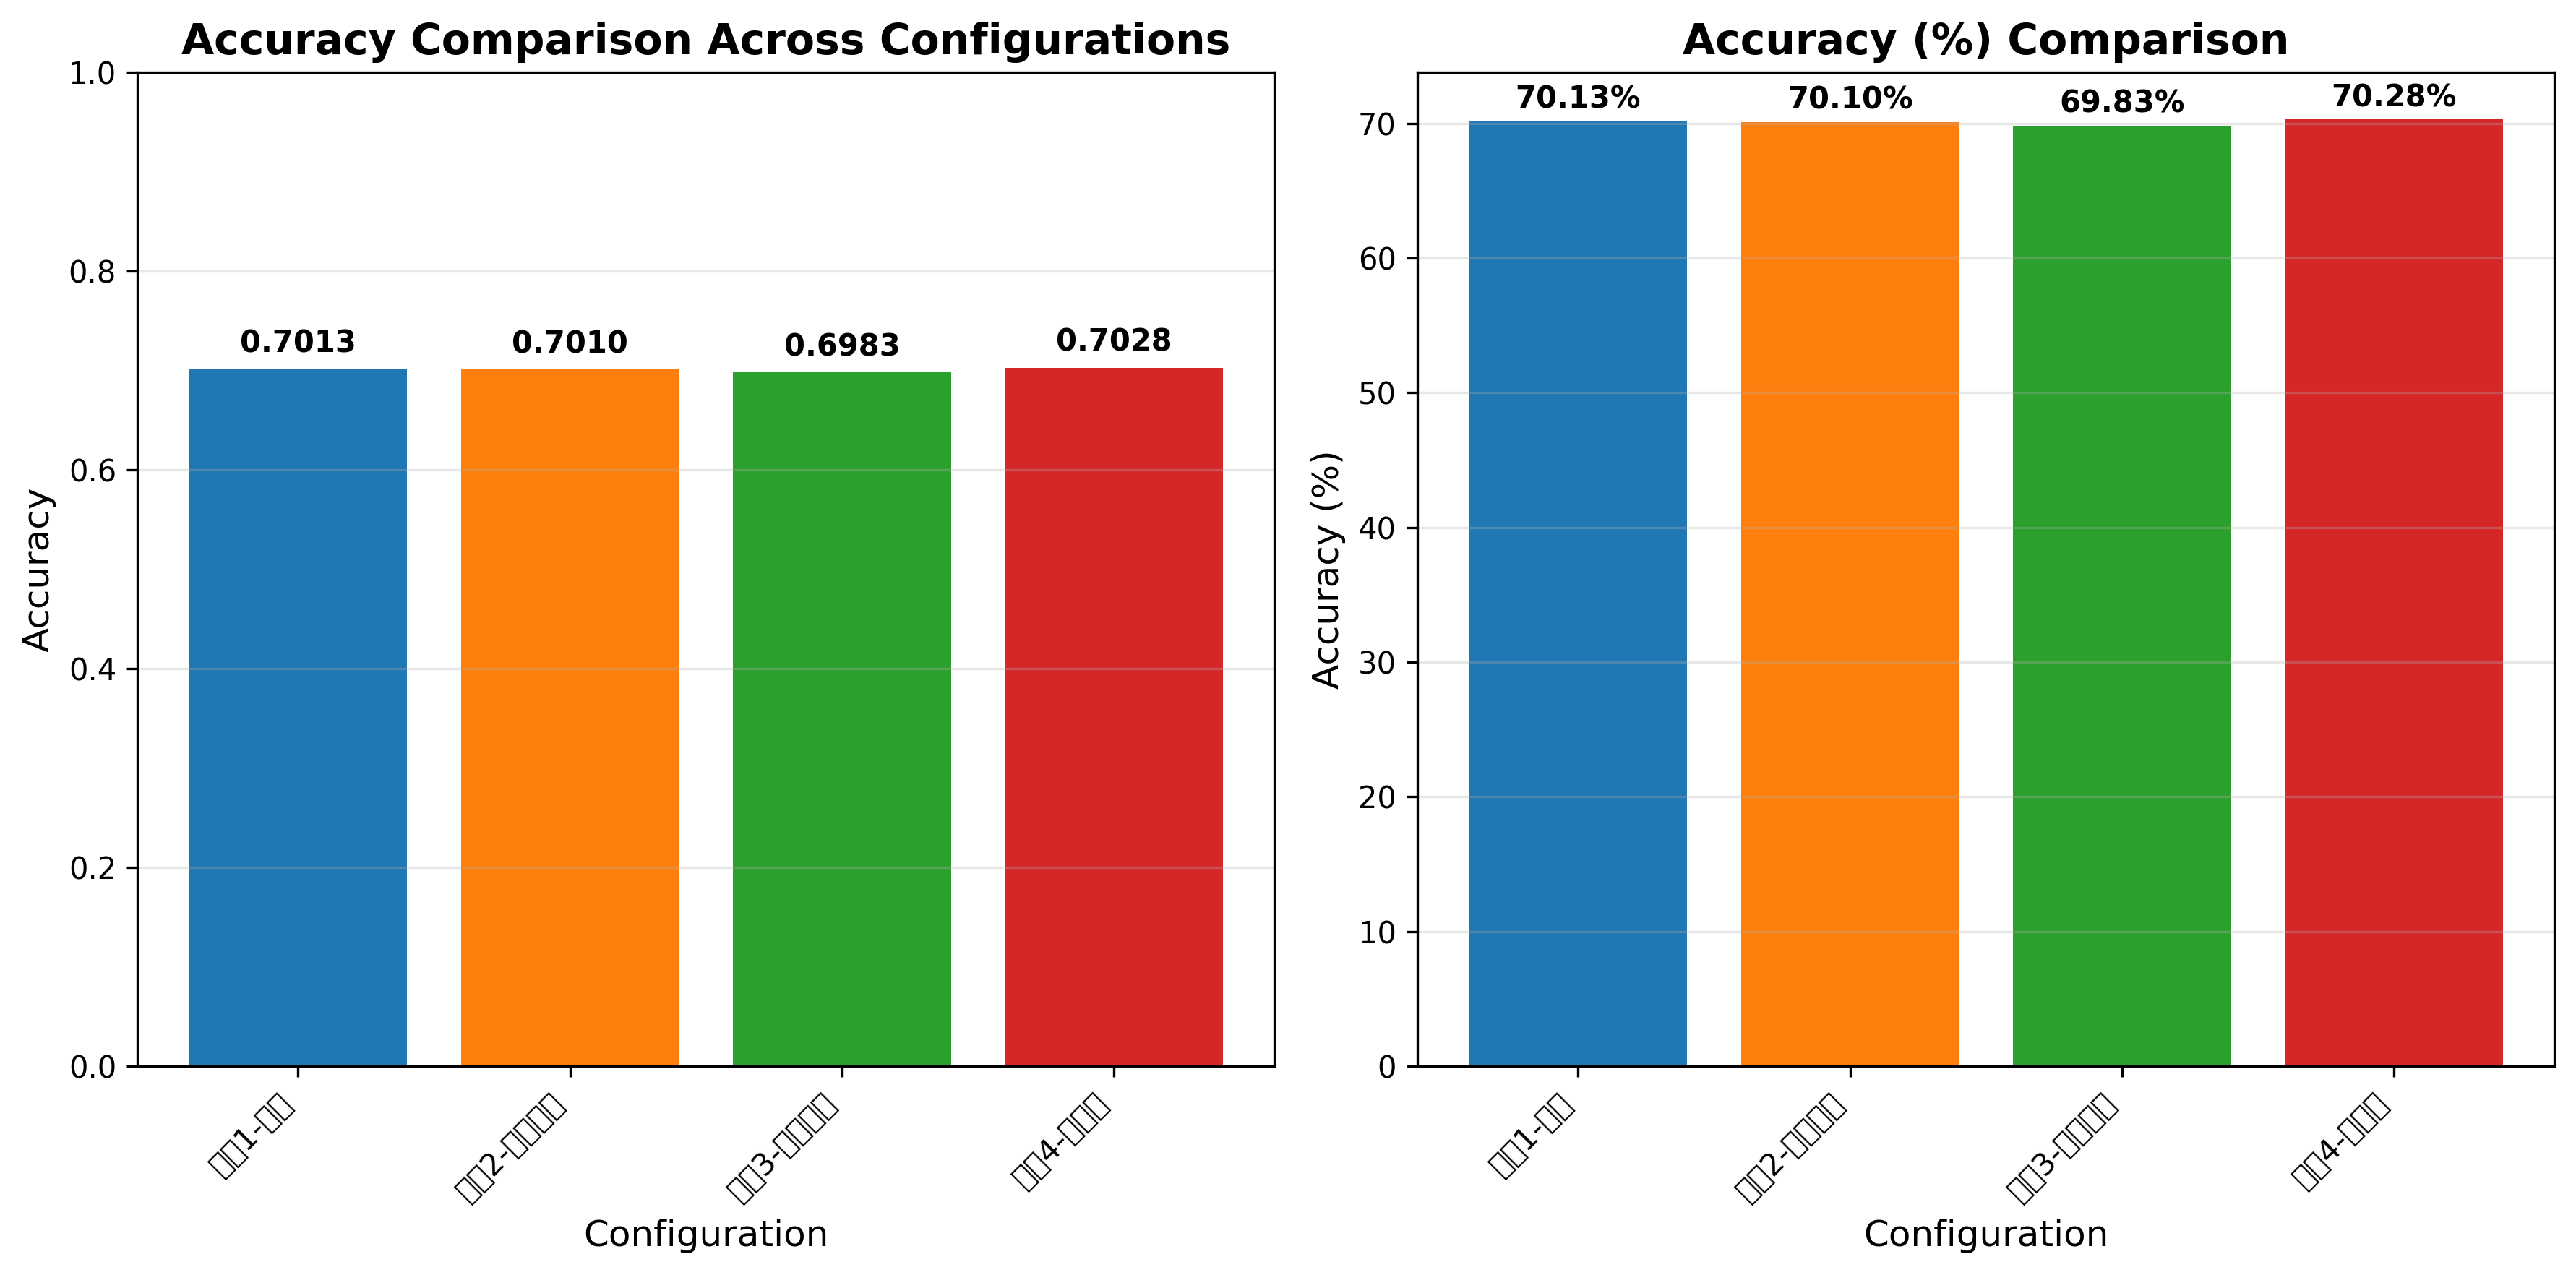

In [2]:
# 显示准确率对比图表
if os.path.exists('accuracy_comparison.png'):
    print("=" * 80)
    print("准确率对比图表")
    print("=" * 80)
    display(Image('accuracy_comparison.png', width=1000))
else:
    print("图表文件 accuracy_comparison.png 未找到。")


## 总结

通过对比4个不同的超参数配置，我们得到了以下结论：

1. **最高准确率**: 配置4（大批次）达到了 **70.284%** 的准确率
2. **最佳配置**: 使用批次大小32，学习率2e-5，训练3个epochs
3. **训练效率**: 配置4不仅准确率最高，训练时间也最短（3.48小时）

所有配置的准确率都在69.8%-70.3%之间，说明模型性能相对稳定。
